In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as tdata
import numpy as np

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.optim as optim

import os
import shutil

pretrained_vgg16 = torchvision.models.vgg16(pretrained = True)


In [2]:
print (pretrained_vgg16)

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [3]:
import matplotlib.pyplot as plt

def plot_loss(loss):

	epoch_range = range(1, len(loss[0]) + 1)

	plot1 = plt.plot(epoch_range, loss[0], 'r', linewidth = 1.4, label = 'training_loss')
	plot2 = plt.plot(epoch_range, loss[1], 'g', linewidth = 1.4, label = 'validation_loss')
	plot3 = plt.plot(epoch_range, loss[2], 'b', linewidth = 1.4, label = 'test_loss')

	plt.title('Loss Plot')
	plt.xlabel('Epochs')
	plt.ylabel('loss')
	plt.legend(loc = 'best')
	plt.show()
    
def plot_accu(accuracy):
	
	epoch_range = range(1, len(accuracy[0]) + 1)

	plot1 = plt.plot(epoch_range, accuracy[0], 'r', linewidth = 1.4, label = 'training_accuracy')
	plot2 = plt.plot(epoch_range, accuracy[1], 'g', linewidth = 1.4, label = 'validation_accuracy')
	plot3 = plt.plot(epoch_range, accuracy[2], 'b', linewidth = 1.4, label = 'test_accuracy')

	plt.title('Accuracy(Percent Corrent) Plot')
	plt.xlabel('Epochs')
	plt.ylabel('accuracy')
	plt.legend(loc = 'best')
	plt.show()

In [4]:
from torch.utils.data import Dataset, DataLoader
import PIL

class Caltech256(Dataset):
    '''
    
    Args:
    
        root_dir (string): Location of Caltech256 Dataset,
        images_per_class (int): Number of images to load per class. Class clutter is ignored
        transform (torch.transform): transformation to perform on input image
    
    Example Usage:
    
        example_transform = transforms.Compose(
            [
                transforms.Scale((224,224)),
                transforms.ToTensor(),
            ]
        )

        caltech256_train = Caltech256("/datasets/Caltech256/256_ObjectCategories/", example_transform, train=True)
        
        train_data = DataLoader(
            dataset = caltech256_train,
            batch_size = 32,
            shuffle = True,
            num_workers = 4
        )
        
        
    '''
    def __init__(self, root_dir, transform = None, datatype = 'train'):
        if datatype == 'train':
            self.images_per_class = 32 
            self.start_image = -64
        elif datatype == 'valid':
            self.images_per_class = 4
            self.start_image = -16
        elif datatype == 'test':
            self.images_per_class = 8
            self.start_image = -32
        self.end_image = self.start_image + self.images_per_class
        self.root_dir = root_dir
        self.transform = transform
        self.cats = os.listdir(root_dir)
        self.files = {}
        self.datatype = datatype
        for cat in self.cats:
            if "clutter" in cat:
                continue

            currdir = os.path.join(root_dir, cat)
            images = os.listdir(currdir)
            images = list(filter(lambda s: s.endswith("jpg"), images))
            assert self.images_per_class <= len(images), "Not enough images in class {c}".format(c = currdir)
                
            for i in range(self.start_image, self.end_image):
                self.files[os.path.join(currdir, images[i])] = int("".join(images[i][0:3]))
                 
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name, label = list(self.files.items())[idx]
        image = PIL.Image.open(img_name).convert("RGB") # A few images are grayscale
        label = torch.Tensor([label])
        

        if self.transform:
            image = self.transform(image)
        sample = (image, label)
        return sample

In [5]:
def data_loader(data_path, batchsize = 32, batch_all = True, img_augment = True, GPU = None):
    
    normalization = transforms.Normalize(
        mean = (0.485, 0.456, 0.406),
        std = (0.229, 0.224, 0.225)
    )
    
    transform = transforms.Compose([
            transforms.Scale((224,224)),
            transforms.ToTensor(),
            normalization
    ])
    
    if img_augment:
        train_trans = transforms.Compose([
            transforms.Scale((224,224)),
            transforms.RandomCrop(size = 224, padding = 20),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalization
        ])
    else:
        train_trans = transform

    caltech256_train = Caltech256(data_path, train_trans, datatype = 'train')
    caltech256_valid = Caltech256(data_path, transform, datatype = 'valid')
    caltech256_test = Caltech256(data_path, transform, datatype = 'test')
    
    if GPU:
        num_workers = 1
        pin_memory = True
    else:
        num_workers = 4
        pin_memory = False
        
    trainloader = DataLoader(dataset = caltech256_train, batch_size = batchsize, shuffle = True, 
                            num_workers = num_workers, pin_memory = pin_memory)
    validloader = DataLoader(dataset = caltech256_valid, batch_size = batchsize, shuffle = False, 
                             num_workers = num_workers, pin_memory = pin_memory)
    testloader = DataLoader(dataset = caltech256_test, batch_size = batchsize, shuffle = False, 
                            num_workers = num_workers, pin_memory = pin_memory)
    
    return trainloader, validloader, testloader

In [6]:
data_path = '/datasets/Caltech256/256_ObjectCategories/'

print (torch.__version__)

use_cuda = torch.cuda.is_available()

print ('use_cuda: ', use_cuda)

dataloaders = data_loader(data_path = data_path, batchsize = 32, GPU = use_cuda)

0.2.0_4
use_cuda:  True


In [7]:
def training(model, criterion, optimizer, epochs, dataloaders, step_size = None, 
             gamma = None, use_cuda = False, model_dir = None, best_model = False):
    
    print ('start training...')
    
    if model_dir is not None:
        if best_model:
            model_dir = model_dir + '/' + 'best_' + model.__class__.__name__ + '_ckpt.pth.tar'
        else:
            model_dir = model_dir + '/' + model.__class__.__name__ + '_ckpt.pth.tar'
        if os.path.isfile(model_dir):
            print ("loading checkpoint '{}'".format(model_dir))
            checkpoint = torch.load(model_dir)
            start_epoch = checkpoint['epoch']
            stats = checkpoint['stats']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print ("loaded checkpoint '{}' (epoch {})".format(model_dir, checkpoint['epoch']))
            trainstat, validstat, teststat = stats
            if isinstance(step_size, int):
                scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            elif isinstance(step_size, list):
                scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                                gamma = gamma, last_epoch = (start_epoch - 1))
            best_valid = np.max(validstat[1])
        else:
            print ("no checkpoint found at '{}'".format(model_dir))
    else:
        start_epoch = 0
        trainstat = [[], []]
        validstat = [[], []]
        teststat = [[], []]
        if isinstance(step_size, int):
            scheduler = lr_scheduler.StepLR(optimizer = optimizer, step_size = step_size, 
                                            gamma = gamma, last_epoch = (start_epoch - 1))
        elif isinstance(step_size, list):
            scheduler = lr_scheduler.MultiStepLR(optimizer = optimizer, milestones = step_size, 
                                            gamma = gamma, last_epoch = (start_epoch - 1))
        best_valid = 0.0
    
    trainloader, validloader, testloader = dataloaders
    
    stop = 0
    filename = model.__class__.__name__ + '_ckpt'
    
    for epoch in np.arange(start_epoch, epochs):
    
        if not use_cuda:
            avg_loss = 0.0
            
        if step_size is not None:
            scheduler.step()

        model.train()

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            labels = labels.long().squeeze(1) - 1
            if use_cuda:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if not use_cuda:
                avg_loss += loss.data[0]

                if i % 100 == 99:
                    print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, avg_loss / 99))
                    avg_loss = 0.0

        model.eval()

        if use_cuda:
            for loader, statlist in [(trainloader, trainstat), (validloader, validstat), 
                                     (testloader, teststat)]:
                total = 0
                correct = 0
                batchloss = 0.0
                batchs = 0
                for dataset in loader:
                    inputs, labels = dataset
                    labels = labels.long().squeeze(1) - 1
                    var_inputs, var_labels = Variable(inputs.cuda()), Variable(labels.cuda())
                    outputs = model(var_inputs)
                    batchloss += criterion(outputs, var_labels).data[0]
                    batchs += 1
                    _, pred_labels = torch.max(outputs.data, 1)
                    correct += (pred_labels == labels.cuda()).sum()
                    total += outputs.size(0)

                statlist[0].append(batchloss / batchs)
                statlist[1].append(correct / total)
            
            print('epoch: %d\ntrain: %.3f  %.1f%%,   valid: %.3f  %.1f%%,   test: %.3f  %.1f%%' 
                  %(epoch + 1, trainstat[0][-1], 100 * trainstat[1][-1], 
                    validstat[0][-1], 100 * validstat[1][-1], 
                    teststat[0][-1], 100 * teststat[1][-1]))
            
            if best_valid < validstat[1][-1]:
                is_best = True
                best_valid = validstat[1][-1]
            else:
                is_best = False
            
            if is_best or (epoch % 10 == 0):
                save_checkpoint({'epoch': epoch + 1,
                                'state_dict': model.state_dict(),
                                'stats': (trainstat, validstat, teststat),
                                'optimizer': optimizer.state_dict()
                                }, is_best, filename)
                
#         if early_stop and epoch >= 2:
#             if validstat[0][-1] >= validstat[0][-2]:
#                 stop += 1
#             else:
#                 stop = 0
            
#             if stop >= 5:
#                 print ('stop training due to rising validloss.')
#                 save_checkpoint({'epoch': epoch + 1,
#                                 'state_dict': model.state_dict(),
#                                 'stats': (trainstat, validstat, teststat),
#                                 'optimizer': optimizer.state_dict()
#                                 }, False, filename)
#                 break

    print ('training finished.')
    
    return trainstat, validstat, teststat
    
    
# the save/load model code can be found at 
# https://github.com/pytorch/examples/blob/master/imagenet/main.py#L267
def save_checkpoint(state, is_best, filename = 'checkpoint'):
    path_name = './model/' + filename + '.pth.tar'
    torch.save(state, path_name)
    if is_best:
        best_path = './model/' + 'best_' + filename + '.pth.tar'
        shutil.copyfile(path_name, best_path)
    print ('model saved.')

In [8]:
class pretrained_Caltech256(nn.Module):
    def __init__(self, pretrained_model, num_classes = 10, trainable = False):
        super(pretrained_Caltech256, self).__init__()
        self.pretrained_model = pretrained_model
        self.trainable = trainable
        if not trainable:
            for param in self.pretrained_model.parameters():
                param.requires_grad = False
        self.pretrained_model.classifier._modules['6'] = nn.Linear(4096, num_classes)
    
    def initialize(self, method = None):
        if method is None:
            pass
        for m in self.modules():
            init = 1
            for param in m.parameters():
                if param.requires_grad == False:
                    init = 0
                    break
            if init:
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
#                         print ('init')
                        nn.init.xavier_uniform(m.weight)
#                         print (m.weight.data)
                        
    def _trainable(self):
        for param in self.pretrained_model.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        x = self.pretrained_model(x)
        return x
            

In [9]:
VGG16_Caltech256 = pretrained_Caltech256(pretrained_vgg16, num_classes = 256)
VGG16_Caltech256.initialize('Xavier')
print (VGG16_Caltech256)

if use_cuda:
    VGG16_Caltech256.cuda()
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(VGG16_Caltech256.pretrained_model.classifier[6].parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

epochs = 50

trainstat, validstat, teststat = training(VGG16_Caltech256, criterion, optimizer, epochs, dataloaders, 
                                          30, 0.1, use_cuda, model_dir = './model')

pretrained_Caltech256 (
  (pretrained_model): VGG (
    (features): Sequential (
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU (inplace)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU (inplace)
      (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU (inplace)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU (inplace)
      (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU (inplace)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU (inplace)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU (inplace)
      (16): MaxPool2d (size=(2, 2), stride=(2, 2),

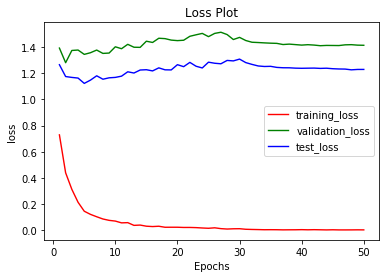

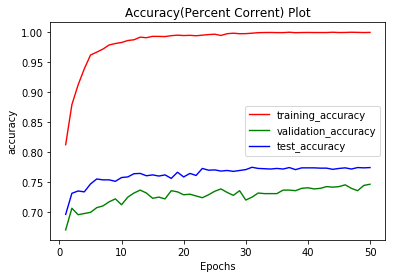

best valid_loss:  1.27912035398
best valid_accuracy:  0.74609375


In [10]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_loss: ',np.min(validstat[0]))
print ('best valid_accuracy: ',np.max(validstat[1]))

In [11]:
class partial_model(nn.Module):
    def __init__(self, pretrained_model):
        super(partial_model, self).__init__()
        self.pretrained_model = pretrained_model
        self.first_layer = nn.Sequential(*list(self.pretrained_model.features.children())[: 2])
        self.last_layer = nn.Sequential(*list(self.pretrained_model.features.children())[: -1])
        self.third_block = nn.Sequential(*list(self.pretrained_model.features.children())[: 17])
        self.forth_block = nn.Sequential(*list(self.pretrained_model.features.children())[: 24])
        for m in [self.first_layer, self.last_layer, self.third_block, self.forth_block]:
            for param in m.parameters():
                param.requires_grad = False
        self.third_classifier = nn.Sequential(
            nn.Linear(256 * 28 * 28, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 256)
        )
        self.forth_classifier = nn.Sequential(
            nn.Linear(512 * 14 * 14, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256)
        )
    
    def set_output_layer(self, output_layer):
        self.output_layer = output_layer
        
    def initialize(self, method = None):
        if method is None:
            pass
        for m in self.modules():
            init = 1
            for param in m.parameters():
                if param.requires_grad == False:
                    init = 0
                    break
            if init:
                if isinstance(m, nn.Conv2d):
                    if method == 'fan-in':
                        fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
                        nn.init.xavier_uniform(m.weight)
                elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                    m.weight.data.fill_(1)
                    m.bias.data.zero_()
                elif isinstance(m, nn.Linear):
                    if method == 'fan-in':
                        fan_in = m.in_features
                        m.weight.data.normal_(0, np.sqrt(1. / fan_in))
                    elif method == 'Xavier':
#                         print ('init')
                        nn.init.xavier_uniform(m.weight)
#                         print (m.weight.data)
        
    def forward(self, x):
        if self.output_layer == 'first':
            x = self.first_layer(x)
        elif self.output_layer == 'last':
            x = self.last_layer(x)
        elif self.output_layer == 'block3':
            x_block3 = self.third_block(x)
            x = x_block3.view(-1, 256 * 28 * 28)
            x = self.third_classifier(x)
        elif self.output_layer == 'block4':
            x_block4 = self.forth_block(x)
            x = x_block4.view(-1, 512 * 14 * 14)
            x = self.forth_classifier(x)
        return x

In [13]:
class Denormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [12]:
def imshow1(img, denormalizer = None):
    if denormalizer is not None:
        img_d = denormalizer(img)
    else:
        img_d = img
    npimg = img_d.numpy()
    if npimg.shape[0] == 3:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow2(image, denormalizer = None):
    if denormalizer is not None:
        image_d = denormalizer(image)
    else:
        image_d = image
    npimg = image_d.numpy()
    plt.imshow(npimg, cmap = 'gray')
    plt.show()

torch.Size([32, 3, 224, 224])
torch.Size([3, 906, 1810])


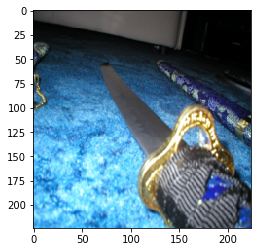

KeyboardInterrupt
Process Process-1:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
  File "/opt/conda/lib/python3.5/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)


In [15]:
dataiter = iter(dataloaders[1])
images, labels = dataiter.next()
print (images.size())
print (torchvision.utils.make_grid(images).size())

image_origin = images[0]

denormalizer = Denormalize(
    mean = (0.485, 0.456, 0.406), 
    std = (0.229, 0.224, 0.225)
)

imshow1(torchvision.utils.make_grid(image_origin), denormalizer)

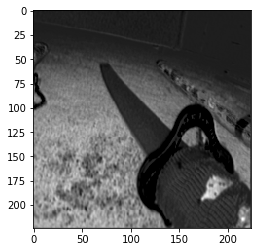

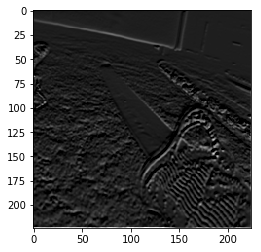

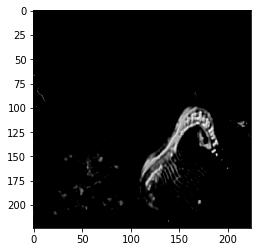

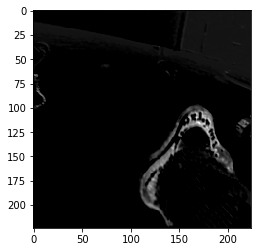

In [16]:
partial_vgg16 = partial_model(pretrained_vgg16)
partial_vgg16.initialize('Xavier')

if use_cuda:
    partial_vgg16.cuda()
    image = Variable(images[0].unsqueeze(0).cuda())
else:
    image = Variable(images[0].unsqueeze(0))

# print (fl_vgg16.first_layer)
# print (fl_vgg16.last_layer)

partial_vgg16.set_output_layer('first')
fmap_first = partial_vgg16(image)
fmap_first = fmap_first.squeeze(0)

imshow2(fmap_first.cpu().data[24])
imshow2(fmap_first.cpu().data[4])
imshow2(fmap_first.cpu().data[7])
imshow2(fmap_first.cpu().data[16])

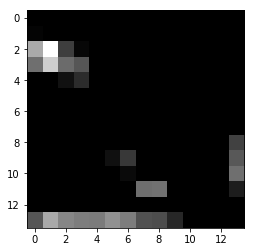

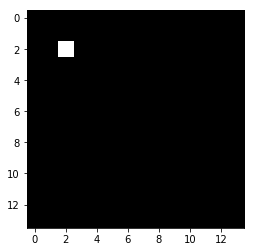

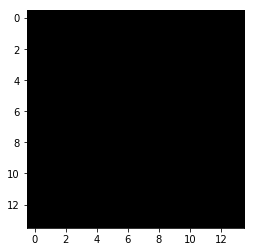

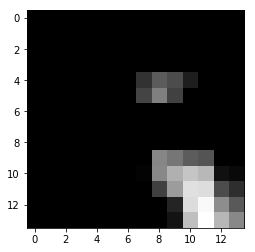

In [17]:
partial_vgg16.set_output_layer('last')
fmap_last = partial_vgg16(image)
fmap_last = fmap_last.squeeze(0)

imshow2(fmap_last.cpu().data[0])
imshow2(fmap_last.cpu().data[10])
imshow2(fmap_last.cpu().data[40])
imshow2(fmap_last.cpu().data[100])

torch.Size([64, 3, 3, 3])
0.0


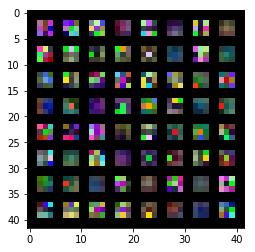

In [16]:
print (partial_vgg16.first_layer[0].weight.data.size())
weight = partial_vgg16.first_layer[0].weight.cpu().data
min_weight = torch.min(weight)

if min_weight < 0:
    weight = weight - min_weight
print (torch.min(weight))
imshow1(torchvision.utils.make_grid(weight))

In [18]:
if use_cuda:
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()

optimizer3 = optim.SGD(partial_vgg16.third_classifier.parameters(), lr = 0.01, momentum = 0.9)
# optimizer = optim.Adam(cnn.parameters(), lr = 0.01)

epochs = 50

partial_vgg16.set_output_layer('block3')
trainstat, validstat, teststat = training(partial_vgg16, criterion, optimizer3, epochs, dataloaders, 
                                          30, 0.1, use_cuda, model_dir = './model')

start training...
loading checkpoint './model/partial_model_ckpt.pth.tar'
loaded checkpoint './model/partial_model_ckpt.pth.tar' (epoch 6)
epoch: 7
train: 5.221  3.6%,   valid: 5.389  3.4%,   test: 5.366  3.4%
model saved.
epoch: 8
train: 5.091  5.1%,   valid: 5.272  4.5%,   test: 5.237  5.1%
model saved.
epoch: 9
train: 4.990  6.3%,   valid: 5.211  5.1%,   test: 5.170  5.3%
model saved.
epoch: 10
train: 4.872  7.4%,   valid: 5.102  6.6%,   test: 5.038  6.9%
model saved.
epoch: 11
train: 4.685  9.1%,   valid: 5.065  6.8%,   test: 4.996  8.1%
model saved.
epoch: 12
train: 4.567  10.8%,   valid: 4.887  7.8%,   test: 4.826  8.7%
model saved.
epoch: 13
train: 4.358  13.5%,   valid: 4.772  10.1%,   test: 4.687  11.5%
model saved.
epoch: 14
train: 4.146  16.0%,   valid: 4.634  12.7%,   test: 4.519  12.8%
model saved.
epoch: 15
train: 3.969  18.0%,   valid: 4.474  13.2%,   test: 4.384  13.9%
model saved.
epoch: 16
train: 3.806  20.6%,   valid: 4.450  15.1%,   test: 4.356  16.0%
model saved.
e

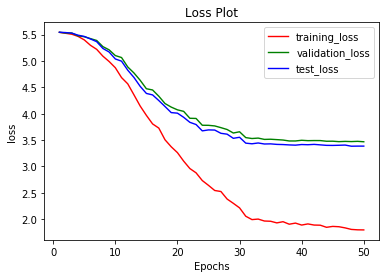

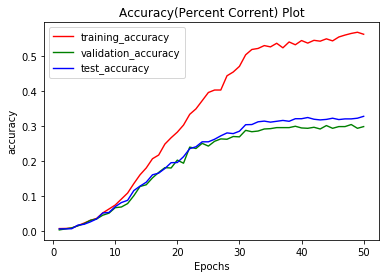

best valid_loss:  3.46788465232
best valid_accuracy:  0.3037109375


In [19]:
loss = (trainstat[0], validstat[0], teststat[0])
accu = (trainstat[1], validstat[1], teststat[1])
plot_loss(loss)
plot_accu(accu)
print ('best valid_loss: ',np.min(validstat[0]))
print ('best valid_accuracy: ',np.max(validstat[1]))

In [ ]:
if use_cuda:
    criterion = nn.CrossEntropyLoss().cuda()
else:
    criterion = nn.CrossEntropyLoss()

optimizer4 = optim.SGD(partial_vgg16.forth_classifier.parameters(), lr = 0.0001, momentum = 0.9)

partial_vgg16.set_output_layer('block4')
trainstat, validstat, teststat = training(partial_vgg16, criterion, optimizer4, 30, dataloaders, 
                                          30, 0.1, use_cuda, model_dir = './model')

start training...
loading checkpoint './model/partial_model_ckpt.pth.tar'
loaded checkpoint './model/partial_model_ckpt.pth.tar' (epoch 21)
